# Image Colorization with U-Net and GAN Tutorial

### A deeper dive into GAN world

As mentioned earlier, we are going to build a GAN (a conditional GAN to be specific) and use an extra loss function, L1 loss. Let's start with the GAN.

As you might know, in a GAN we have a generator and a discriminator model which learn to solve a problem together. In our setting, the generator model takes a grayscale image (1-channel image) and produces a 2-channel image, a channel for \*a and another for \*b. The discriminator, takes these two produced channels and concatenates them with the input grayscale image and decides whether this new 3-channel image is fake or real. Of course the discriminator also needs to see some real images (3-channel images again in Lab color space) that are not produced by the generator and should learn that they are real. 

So what about the "condition" we mentioned? Well, that grayscale image which both the generator and discriminator see is the condition that we provide to both models in our GAN and expect that the they take this condition into consideration.

### Loss function we optimize

The earlier loss function helps to produce good-looking colorful images that seem real, but to further help the models and introduce some supervision in our task, we combine this loss function with L1 Loss (you might know L1 loss as mean absolute error) of the predicted colors compared with the actual colors:

![L1 loss](./files/l1_loss.jpg)

If we use L1 loss alone, the model still learns to colorize the images but it will be conservative and most of the time uses colors like "gray" or "brown" because when it doubts which color is the best, it takes the average and uses these colors to reduce the L1 loss as much as possible (it is similar to the blurring effect of L1 or L2 loss in super resolution task). Also, the L1 Loss is preferred over L2 loss (or mean squared error) because it reduces that effect of producing gray-ish images. So, our combined loss function will be:

![loss](./files/loss.jpg)

where _**λ**_ is a coefficient to balance the contribution of the two losses to the final loss (of course the discriminator loss does not involve the L1 loss).

Okay. I think it's enough for theory! Let's get our hands dirty with the code! In the following section, **I first introduce the code to implement the paper** and in the section after that, **I will introduce a better strategy to get really amazing results in one or two hours of training and without needing huge amount of data!**

## 1 - Implementing the paper - Our Baseline

### 1.1- Loading Image Paths

The paper uses the whole ImageNet dataset (with 1.3 million images!) but here I'm using only 8,000 images from COCO dataset for training which I had available on my device. So our training set size is 0.6% of what was used in the paper!
You can use almost any dataset for this task as far as it contains many different scenes and locations which you hope it will learn to colorize. You can use ImageNet for example but you will only need 8000 of its images for this project.

In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None
print("IMPORTED SUCCESS")

IMPORTED SUCCESS


In [6]:
if use_colab == True:
    path = coco_path
else:
    trainPath = "data/train_color"
    testPath = "data/test_color2"
    
trainPaths = glob.glob(trainPath + "/*.jpg") # Grabbing all the image file names
testPaths = glob.glob(testPath + "/*.jpg")
np.random.seed(123)
trainPaths = np.random.choice(trainPaths, 500, replace=False) # choosing 1000 images randomly

print(len(trainPaths), len(testPaths))

500 3


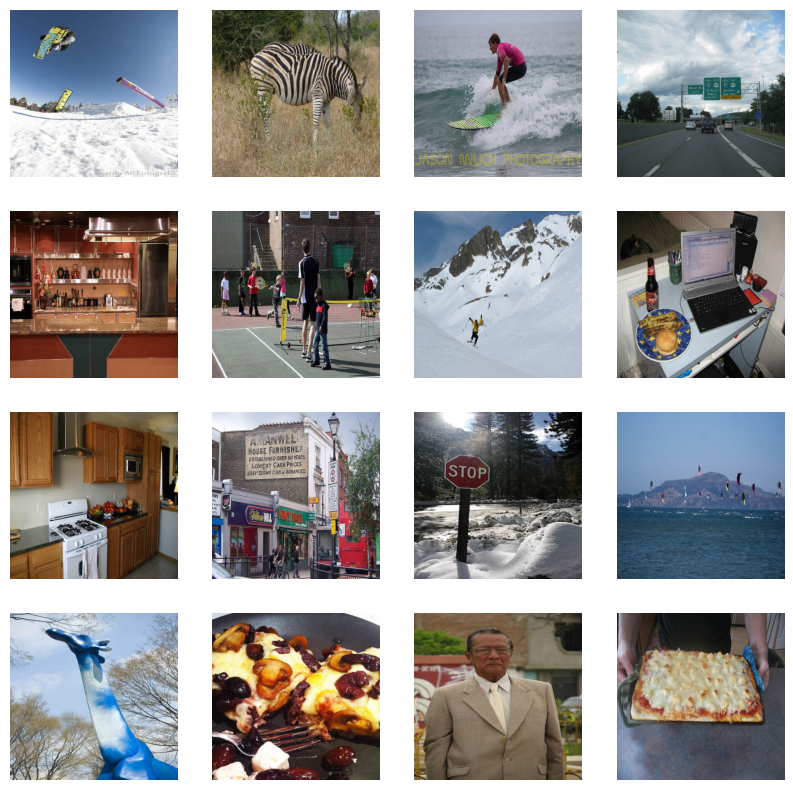

In [3]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), trainPaths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

### 1.2- Making Datasets and DataLoaders

I hope the code is self-explanatory. I'm resizing the images and flipping horizontally (flipping only if it is training set) and then I read an RGB image, convert it to Lab color space and separate the first (grayscale) channel and the color channels as my inputs and targets for the models  respectively. Then I'm making the data loaders.

In [13]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(),
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE), interpolation=InterpolationMode.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths

    
    def __getitem__(self, idx):
        print(self.paths[idx])
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        print(L)
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=pin_memory)
    return dataloader

In [14]:
train_dl = make_dataloaders(paths=trainPaths, split='train')
test_dl = make_dataloaders(paths=testPaths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(test_dl))

data/train_color/image3937.jpg
tensor([[[ 0.0198,  0.0198,  0.0120,  ..., -0.3199, -0.3199, -0.3199],
         [ 0.0276,  0.0198,  0.0198,  ..., -0.3199, -0.3199, -0.3199],
         [ 0.0276,  0.0276,  0.0198,  ..., -0.3199, -0.3199, -0.3199],
         ...,
         [ 0.8264,  0.7268,  0.8118,  ...,  0.7102,  0.7263,  0.6969],
         [ 0.8480,  0.7841,  0.7421,  ...,  0.7261,  0.7288,  0.6708],
         [ 0.8900,  0.7846,  0.7634,  ...,  0.7854,  0.7532,  0.6647]]])
data/train_color/image1902.jpg
tensor([[[ 0.2782,  0.3747,  0.1810,  ..., -0.2718, -0.4535, -0.4979],
         [ 0.2954,  0.4294,  0.1591,  ..., -0.2541, -0.4954, -0.5244],
         [ 0.4705,  0.4306,  0.2674,  ..., -0.2843, -0.4334, -0.4803],
         ...,
         [ 0.0159,  0.1608,  0.2034,  ...,  0.1072,  0.2605,  0.2131],
         [-0.1276,  0.0834,  0.1501,  ...,  0.0483,  0.0247,  0.1184],
         [-0.0954,  0.1531,  0.0804,  ...,  0.1199, -0.0929,  0.1044]]])
data/train_color/image0283.jpg
tensor([[[ 0.3769,  0.3

### 1.3- Generator proposed by the paper

This one is a little complicated and needs explanation. This code implements a U-Net to be used as the generator of our GAN. The details of the code are out of the scope of this article but the important thing to understand is that it makes the U-Net from the middle part of it (down in the U shape) and adds down-sampling and up-sampling modules to the left and right of that middle module (respectively) at every iteration until it reaches the input module and output module. Look at the following image that I made from one of the images in the article to give you a better sense of what is happening in the code:

![unet](./files/unet.png)

The blue rectangles show the order in which the related modules are built with the code. The U-Net we will build has more layers than what is depicted in this image but it suffices to give you the idea. Also notice in the code that we are going 8 layers down, so if we start with a 256 by 256 image, in the middle of the U-Net we will get a 1 by 1 (256 / 2⁸) image and then it gets up-sampled to produce a  256 by 256 image (with two channels). This code snippet is really exciting and I highly recommend to play with it to fully grasp what every line of it is doing.

In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

### 1.4- Discriminator

The architecture of our discriminator is rather straight forward. This code implements a model by stacking blocks of Conv-BatchNorm-LeackyReLU to decide whether the input image is fake or real. Notice that the first and last blocks do not use normalization and the last block has no activation function (it is embedded in the loss function we will use).

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

Let's take a look at its blocks:

In [ ]:
PatchDiscriminator(3)

And its output shape:

In [ ]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

We are using a "Patch" Discriminator here. Okay, what is it?! In a vanilla discriminator, the model outputs one number (a scaler) which represents how much the model thinks the input (which is the whole image) is real (or fake). In a patch discriminator, the model outputs one number for every patch of say 70 by 70 pixels of the input image and for each of them decides whether it is fake or not separately. Using such a model for the task of colorization seems reasonable to me because the local changes that the model needs to make are really important and maybe deciding on the whole image as in vanilla discriminator cannot take care of the subtleties of this task. Here, the model's output shape is 30 by 30 but it does not mean that our patches are 30 by 30. The actual patch size is obtained when you compute the receptive field of each of these 900 (30 multiplied by 30) output numbers which in our case will be 70 by 70.

### 1.5- GAN Loss

This is a handy class we can use to calculate the GAN loss of our final model. In the __init__ we decide which kind of loss we're going to use (which will be "vanilla" in our project) and register some constant tensors as the "real" and "fake" labels. Then when we call this module, it makes an appropriate tensor full of zeros or ones (according to what we need at the stage) and computes the loss.

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

### 1.x Model Initialization

In the TowardsDataScince article, I didn't explain this function. Here is our logic to initialize our models. We are going to initialize the weights of our model with a mean of 0.0 and standard deviation of 0.02 which are the proposed hyperparameters in the article:

In [ ]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

### 1.6- Putting everything together

This class brings together all the previous parts and implements a few methods to take care of training our complete model. Let's investigate it. 

In the __init__ we define our generator and discriminator using the previous functions and classes we defined and we also initialize them with init_model function which I didn't explain here but you can refer to my GitHub repository to see how it works. Then we define our two loss functions and the optimizers of the generator and discriminator. 

The whole work is being done in optimize method of this class. First and only once per iteration (batch of training set) we call the module's forward method and store the outputs in fake_color variable of the class. 

Then, we first train the discriminator by using backward_D method in which we feed the fake images produced by generator to the discriminator (make sure to detach them from the generator's graph so that they act as a constant to the discriminator, like normal images) and label them as fake. Then we feed a batch of real images from training set to the discriminator and label them as real. We add up the two losses for fake and real and take the average and then call the backward on the final loss. 
Now, we can train the generator. In backward_G method we feed the discriminator the fake image and try to fool it by assigning real labels to them and calculating the adversarial loss. As I mentioned earlier, we use L1 loss as well and compute the distance between the predicted two channels and the target two channels and multiply this loss by a coefficient (which is 100 in our case) to balance the two losses and then add this loss to the adversarial loss. Then we call the backward method of the loss.

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

### 1.xx Utility functions

These functions were nor included in the explanations of the TDS article. These are just some utility functions to log the losses of our network and also visualize the results during training. So here you can check them out:

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

### 1.7- Training function

I hope this code is self-explanatory. Every epoch takes about 4 minutes on not a powerful GPU as Nvidia P5000. So if you are using 1080Ti or higher, it will be much faster.

In [ ]:
def train_model(model, train_dl, epochs, display_every=25):
    data = next(iter(test_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

model = MainModel()
train_model(model, train_dl, 25)

Every epoch takes about 3 to 4 minutes on Colab. After about 20 epochs you should see some reasonable results.